In [1]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import SALib as sa
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split


2023-12-09 09:11:14.317728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [3]:
# data = results.to_dataframe()


In [4]:
# data.to_csv('4Mrows.csv', index=False)


In [5]:
# data = pd.read_csv('../raw_data/all_data_30_horizon_with_day_of_week.csv')


In [6]:
# data.columns


## Running preprocessor

In [7]:
# processed_data = preprocess(data, raw_od_columns=['OriginCty', 'DestinationCty'], raw_od_ctry=['OriginCtry', 'DestinationCtry'] , as_ratio=True)
# processed_data


In [8]:
# processed_data.to_csv('processed_data.csv', index=False)


In [9]:
data = pd.read_csv('../raw_data/processed_data.csv')


In [10]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'dayofweek', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
   

### Checking the distribution of the target (Score_Z_score_0_50)


In [11]:
data.value_counts()


OriginApt  OriginCty  OriginCtry  DestinationApt  DestinationCty  DestinationCtry  TravelHorizonDays  TravelDistanceKm  SelfTransfer  Stops  DurationMin  Seg_0_OriginIATA  Seg_0_OriginName             Seg_0_DestinationIATA  Seg_0_DestinationName                   dayofweek  Seg_0_OperatingCarrierIATA  Seg_0_TravelDistanceKm  Seg_1_OriginIATA  Seg_1_OriginName                        Seg_1_DestinationIATA  Seg_1_DestinationName  Seg_1_OperatingCarrierIATA  Seg_1_TravelDistanceKm  Seg_2_OriginIATA  Seg_2_OriginName       Seg_2_DestinationIATA  Seg_2_DestinationName  Seg_2_OperatingCarrierIATA  Seg_2_TravelDistanceKm  Seg_3_OriginIATA  Seg_3_OriginName       Seg_3_DestinationIATA  Seg_3_DestinationName  Seg_3_OperatingCarrierIATA  Seg_3_TravelDistanceKm  Seg_0_DurationMin  Seg_1_DurationMin  Seg_2_DurationMin  Seg_3_DurationMin  passengers  SearchLowestRatio  ItinLowestRatio  Price     PricePerPax  ItineraryRedirects  ODRedirects  redirect_ratio  OD      OD_ctry  total_travel_time  total_l

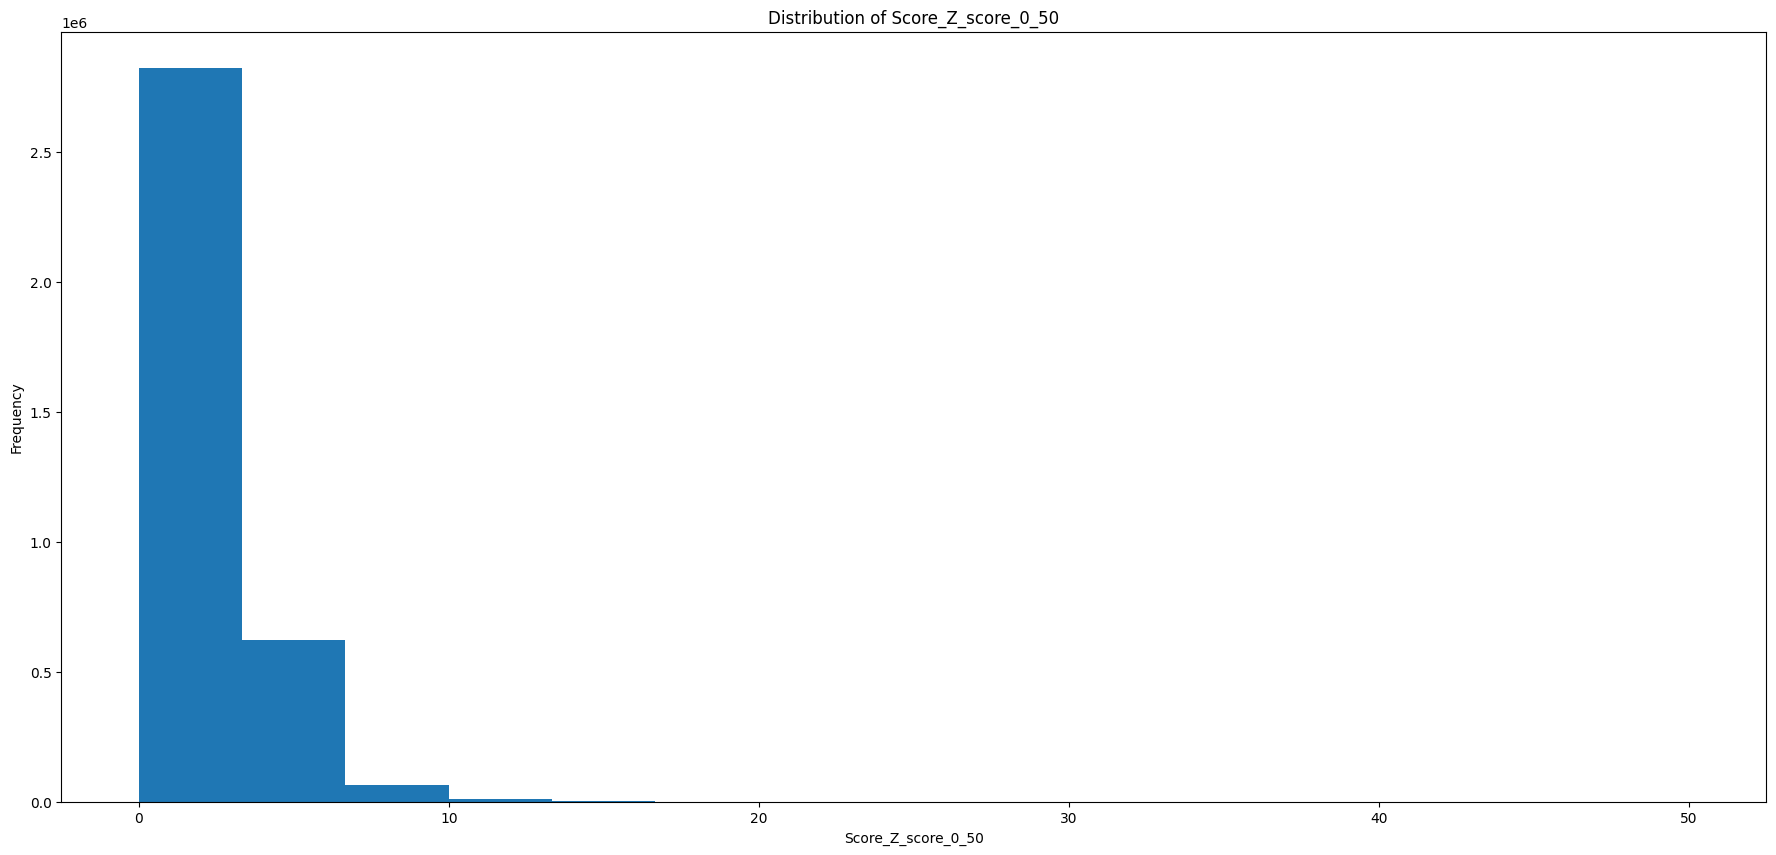

In [12]:
plt.figure(figsize=(22, 10))
plt.hist(data["Score_Z_score_0_50"], bins=15)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50")
plt.show()


In [16]:
view.columns


Index(['ODRedirects per OD', 'cumulative_sum_ODRedirects'], dtype='object')

In [17]:
view = data.groupby(["OD", "TravelHorizonDays"])["ODRedirects"].mean()
view = view.groupby("OD").sum()
view = view.sort_values(ascending=False)
view = view.to_frame(name="ODRedirects_per_OD")
view["cumulative_sum_ODRedirects"] = view.cumsum()
view["cumulative_perc_ODRedirects"] = 100 * view.cumulative_sum_ODRedirects / view.ODRedirects_per_OD.sum()
view.reset_index(inplace=True)
view.ODRedirects_per_OD.sum()
view.head(20)


,OD,ODRedirects_per_OD,cumulative_sum_ODRedirects,cumulative_perc_ODRedirects
0,DELBOM,25343.0,25343.0,0.313046
1,BOMDEL,23571.0,48914.0,0.604203
2,SELTYO,22249.0,71163.0,0.879030
3,TYOSEL,22154.0,93317.0,1.152684
4,SELOSA,19895.0,113212.0,1.398434
5,OSASEL,19492.0,132704.0,1.639206
6,BKKSEL,18745.0,151449.0,1.870750
7,SELBKK,18430.0,169879.0,2.098404
8,CJUSEL,18067.0,187946.0,2.321574
9,SELCJU,17979.0,205925.0,2.543657


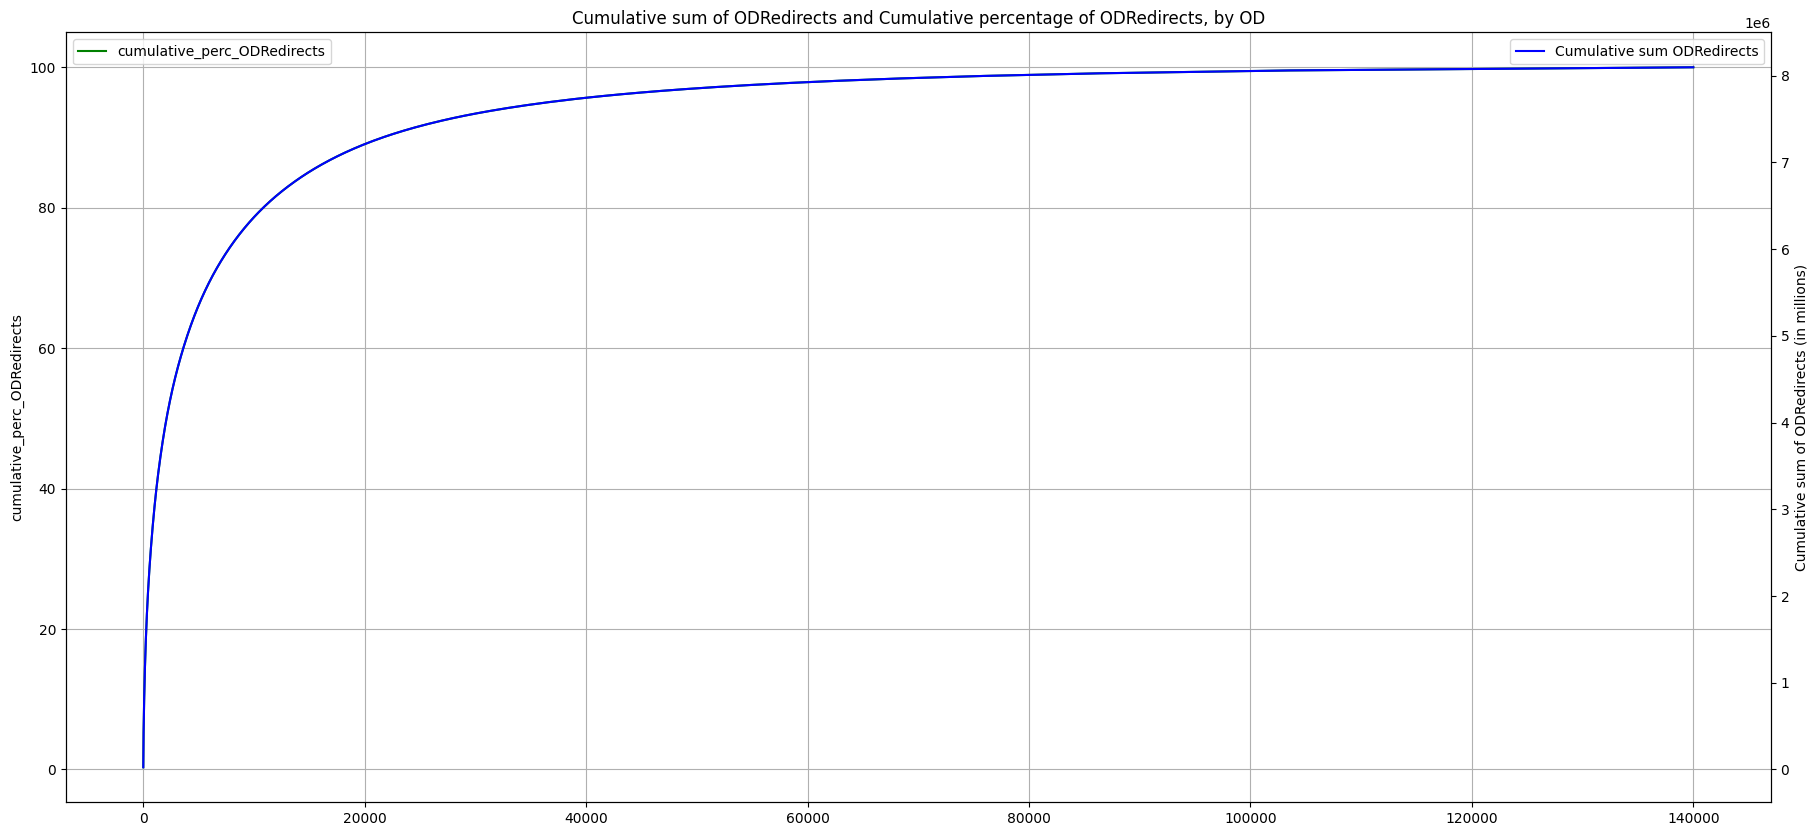

In [23]:
plt.figure(figsize=(22,10))


# First plot with twinx()
ax1 = view["cumulative_perc_ODRedirects"].plot(kind="line", color="green", label="cumulative_perc_ODRedirects", grid=True)
plt.ylabel("cumulative_perc_ODRedirects")

#Second Plot
ax2 = ax1.twinx()
view["cumulative_sum_ODRedirects"].plot(kind="line", color="blue", ax=ax2, label="Cumulative sum ODRedirects")
plt.ylabel("Cumulative sum of ODRedirects (in millions)")
plt.title("Cumulative sum of ODRedirects and Cumulative percentage of ODRedirects, by OD")


# Optional: Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


In [38]:
view.sum()


8095628.0

In [52]:
view.describe()


count    140001.000000
mean         57.825501
std         357.584729
min           1.000000
25%           1.000000
50%           4.000000
75%          18.000000
max       25343.000000
Name: ODRedirects, dtype: float64

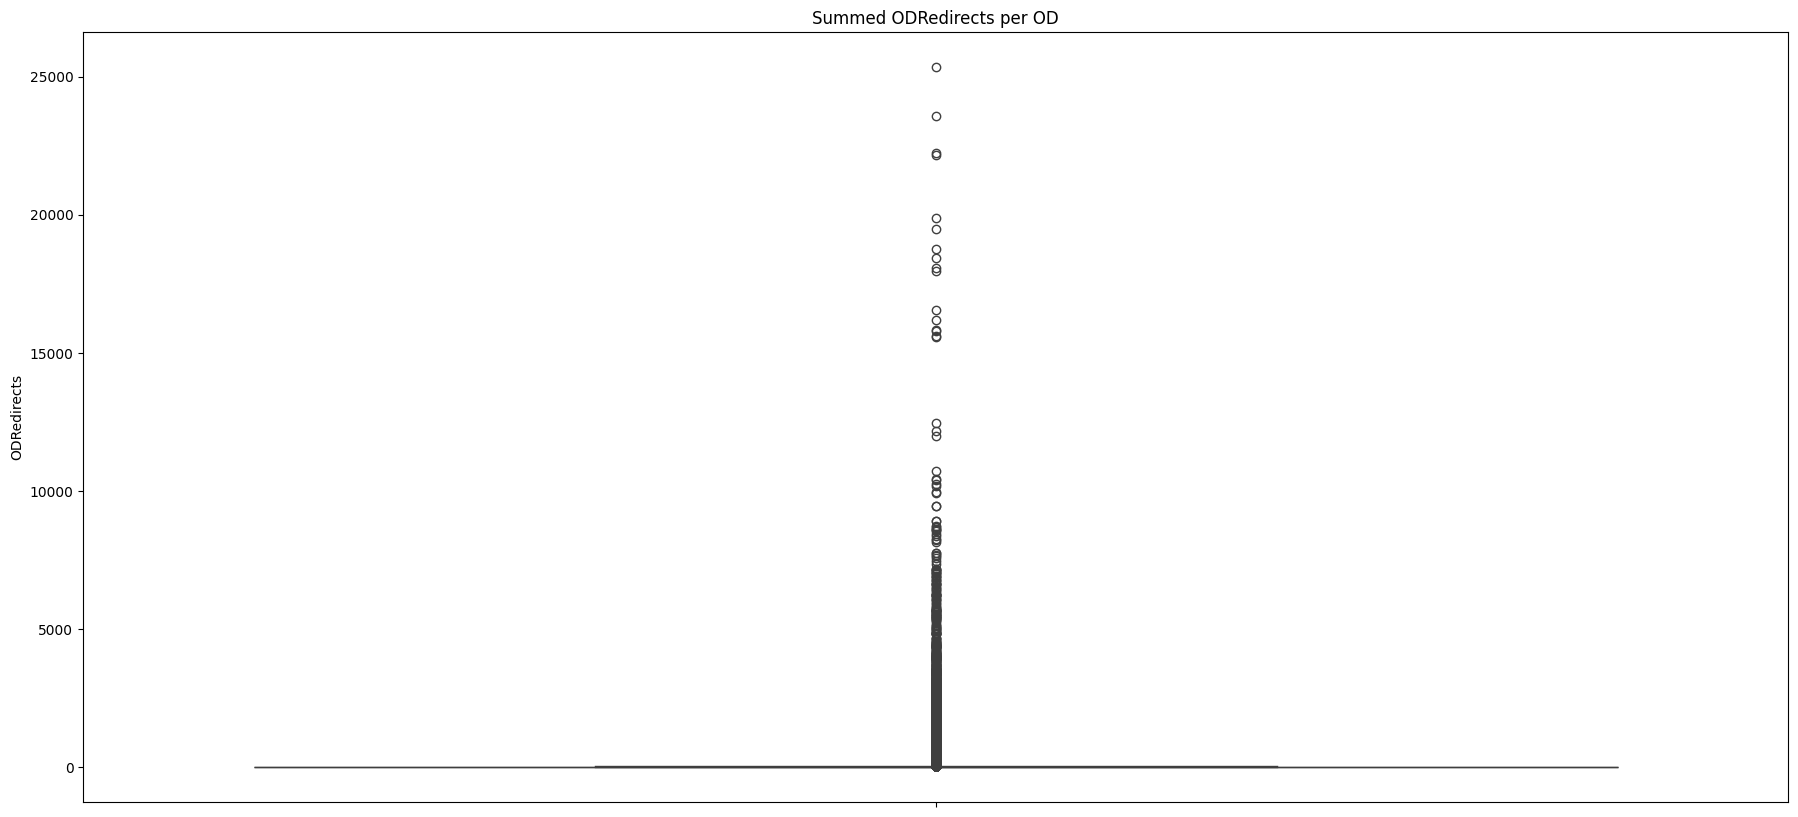

In [45]:
plt.figure(figsize=(22, 10))
sns.boxplot(data=view)
plt.title("Summed ODRedirects per OD")
plt.show()


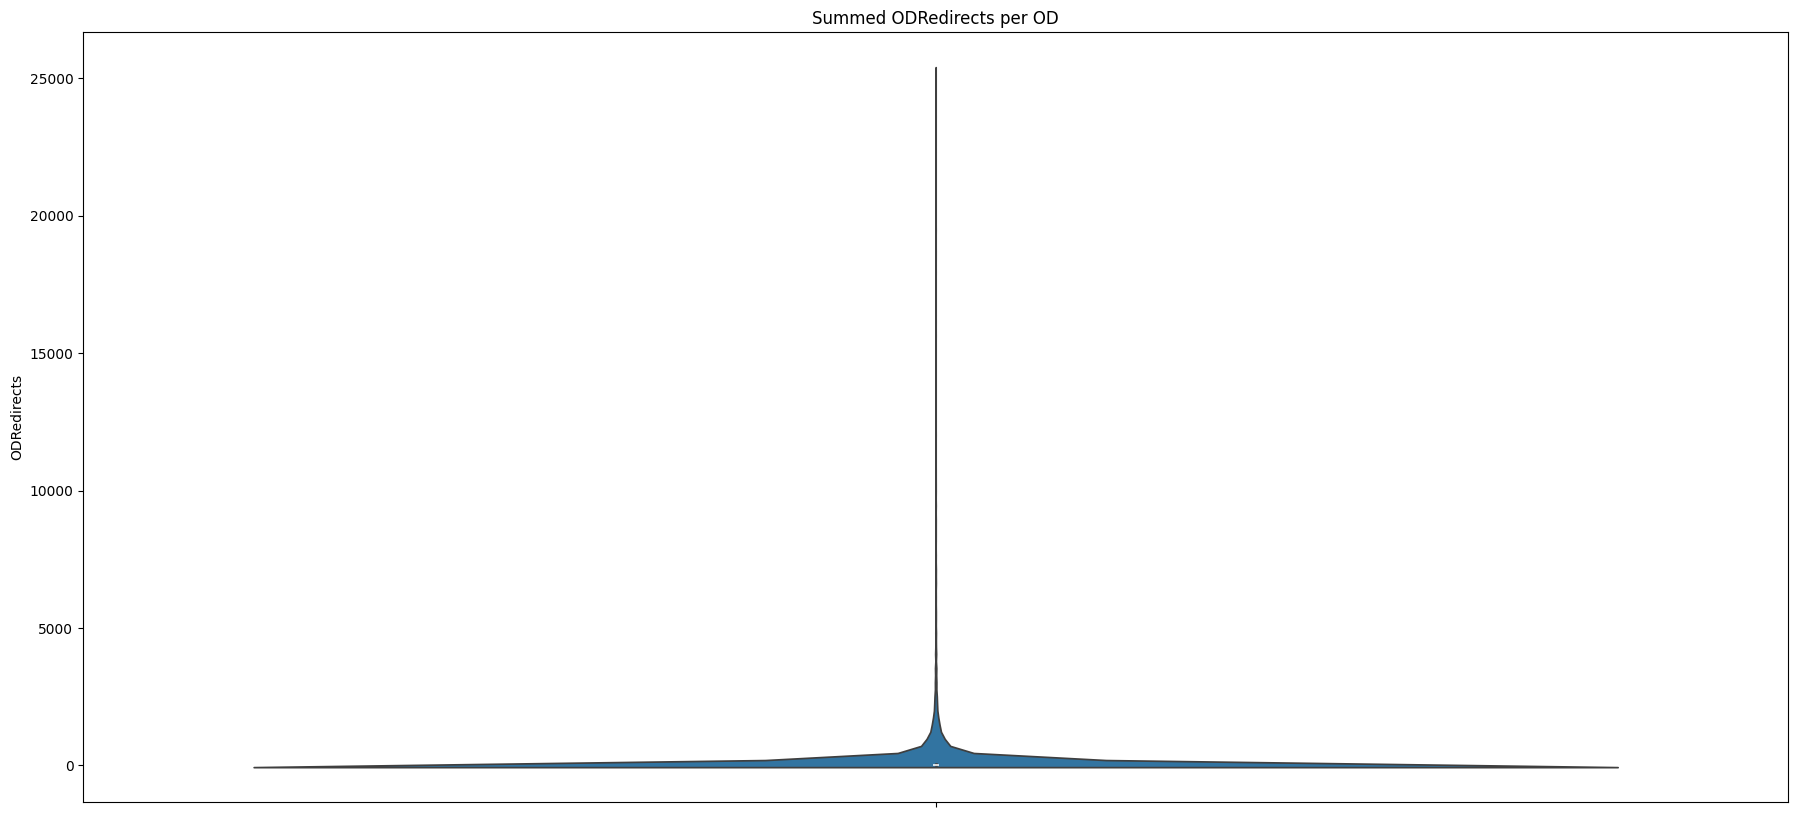

In [44]:
plt.figure(figsize=(22, 10))
sns.violinplot(data=view)
plt.title("Summed ODRedirects per OD")
plt.show()


<Figure size 2200x1000 with 0 Axes>

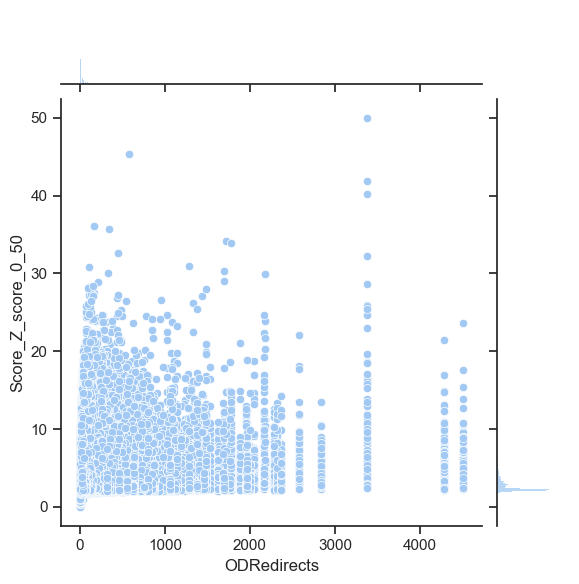

In [109]:
plt.figure(figsize=(22, 10))
sns.jointplot(data=data, x="ODRedirects", y="Score_Z_score_0_50", kind="scatter")


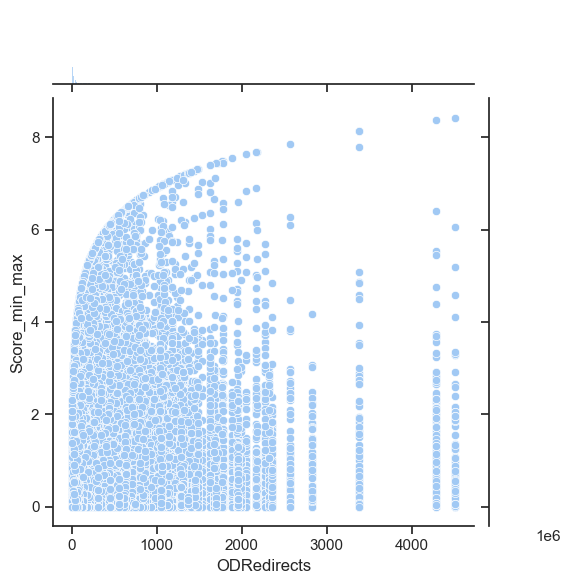

In [106]:
sns.jointplot(data=data, x="ODRedirects", y="Score_min_max", kind="scatter")
plt.show()


## Continuing the Pre-Processing

In [11]:
model_columns = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer',
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax', 'Score_Z_score_0_50']

model_data = data[model_columns].copy()


In [12]:
model_data["SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [13]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
0,NaN,4,1,0.109375,NaN,1280.680000,NaN
1,NaN,1,1,0.359223,NaN,746.140000,NaN
2,NaN,29,0,0.000000,NaN,239.380000,NaN
3,NaN,17,1,0.247059,NaN,1109.020000,NaN
4,NaN,9,0,0.000000,NaN,158.083333,NaN


In [14]:
model_data.dtypes


TravelDistanceKm               float64
TravelHorizonDays                int64
SelfTransfer                     int64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
Score_Z_score_0_50             float64
dtype: object

In [15]:
model_data.isna().sum()


TravelDistanceKm                56236
TravelHorizonDays                   0
SelfTransfer                        0
total_layover_time_ratio            0
extra_travel_distance_ratio     56236
PricePerPax                         0
Score_Z_score_0_50             172056
dtype: int64

In [16]:
model_data["Score_Z_score_0_50"].fillna(0, inplace=True)


In [17]:
model_data.isna().sum()


TravelDistanceKm               56236
TravelHorizonDays                  0
SelfTransfer                       0
total_layover_time_ratio           0
extra_travel_distance_ratio    56236
PricePerPax                        0
Score_Z_score_0_50                 0
dtype: int64

In [18]:
# corr_matrix = model_data.corr()
# corr_matrix


In [19]:
# plt.figure(figsize=(18,8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.show()


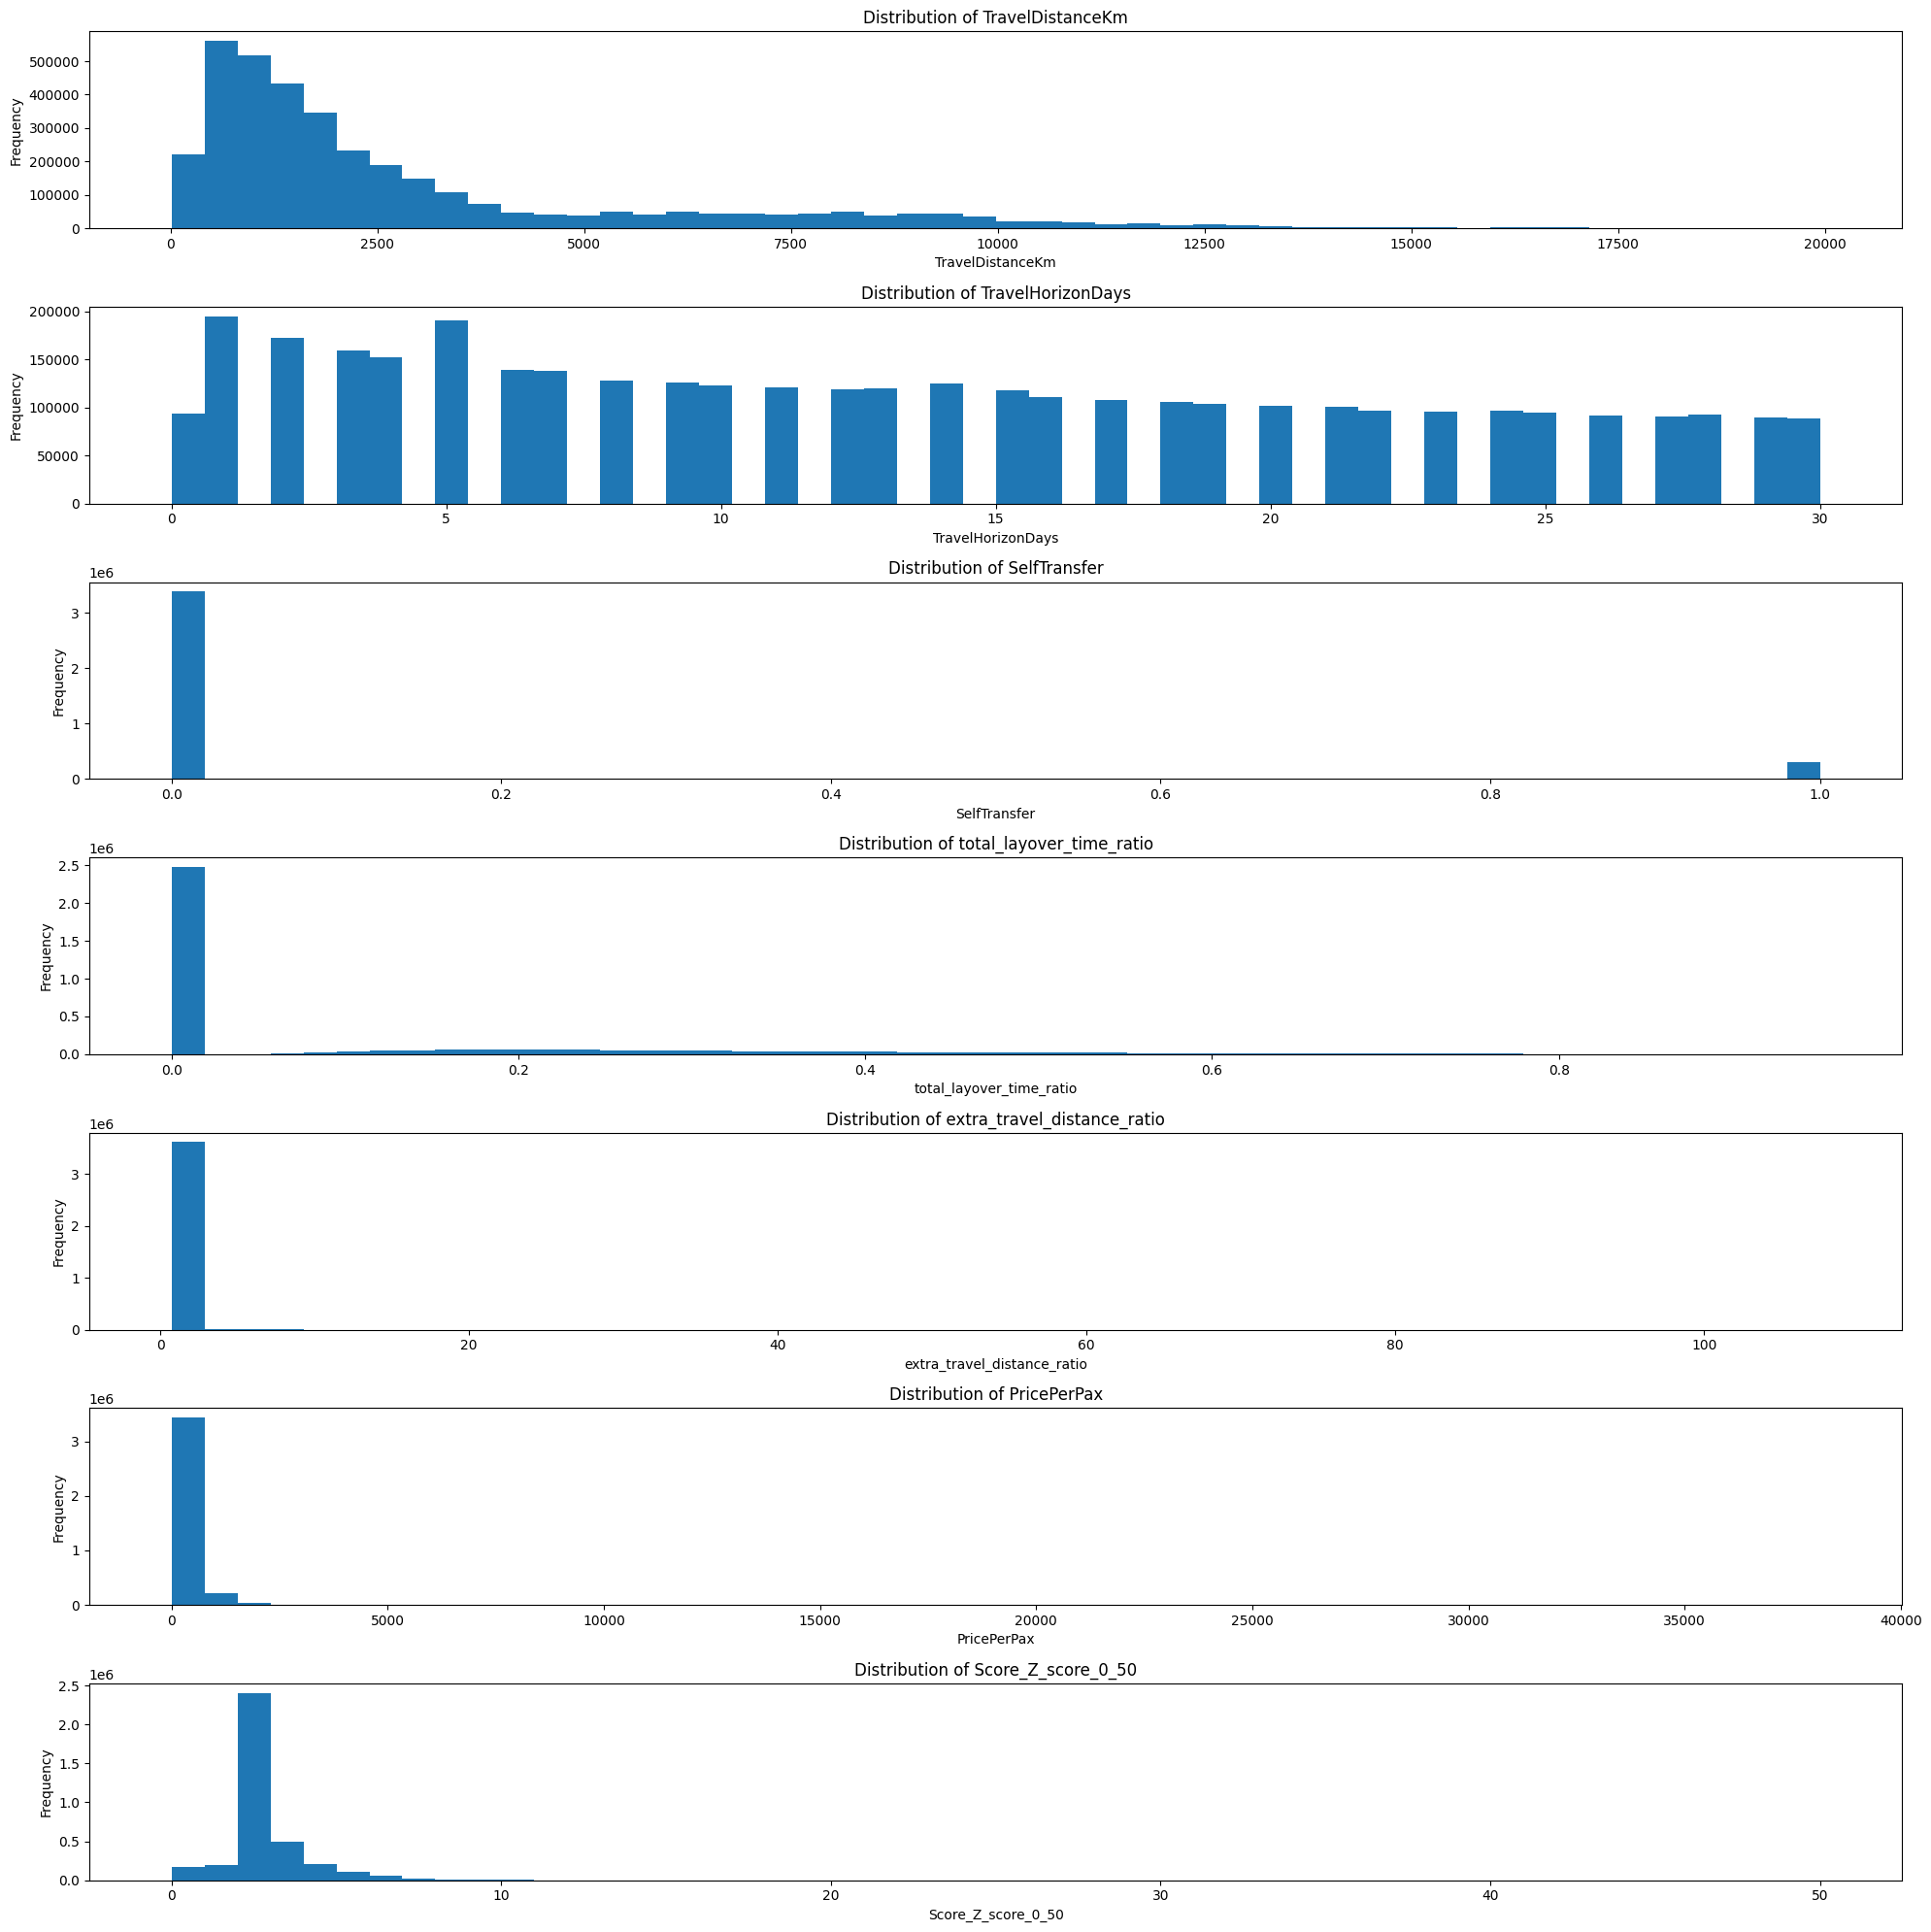

In [20]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist(bins=50)
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Feature Engineering
- Log of extra_travel_distance
- Log of PricePerPax
- Log of total_layover_time_ratio
- Log of TravelDistanceKm

New target reqiures replacment of NaNs by zeros

In [21]:
model_data.dropna(inplace=True)


In [22]:
model_data.isna().any().any()


False

In [23]:
model_data.isna().sum()


TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
Score_Z_score_0_50             0
dtype: int64

In [26]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
31,8.887791,28,0,0.268990,0.706452,6.274753,4.105183
32,8.706159,10,0,0.177514,0.739656,6.381469,0.000000
33,8.069968,22,0,0.212333,0.718633,5.734635,0.000000
34,9.060099,3,0,0.156569,0.766354,7.056106,3.051040
35,8.558911,17,0,0.208639,0.703550,6.861041,2.201084


In [25]:
# List of columns to transform
columns_to_transform = ['extra_travel_distance_ratio', 'PricePerPax', 'total_layover_time_ratio', 'TravelDistanceKm']

# Apply the transformation in a loop
for column in columns_to_transform:
    model_data.loc[:, column] = np.log1p(model_data[column])


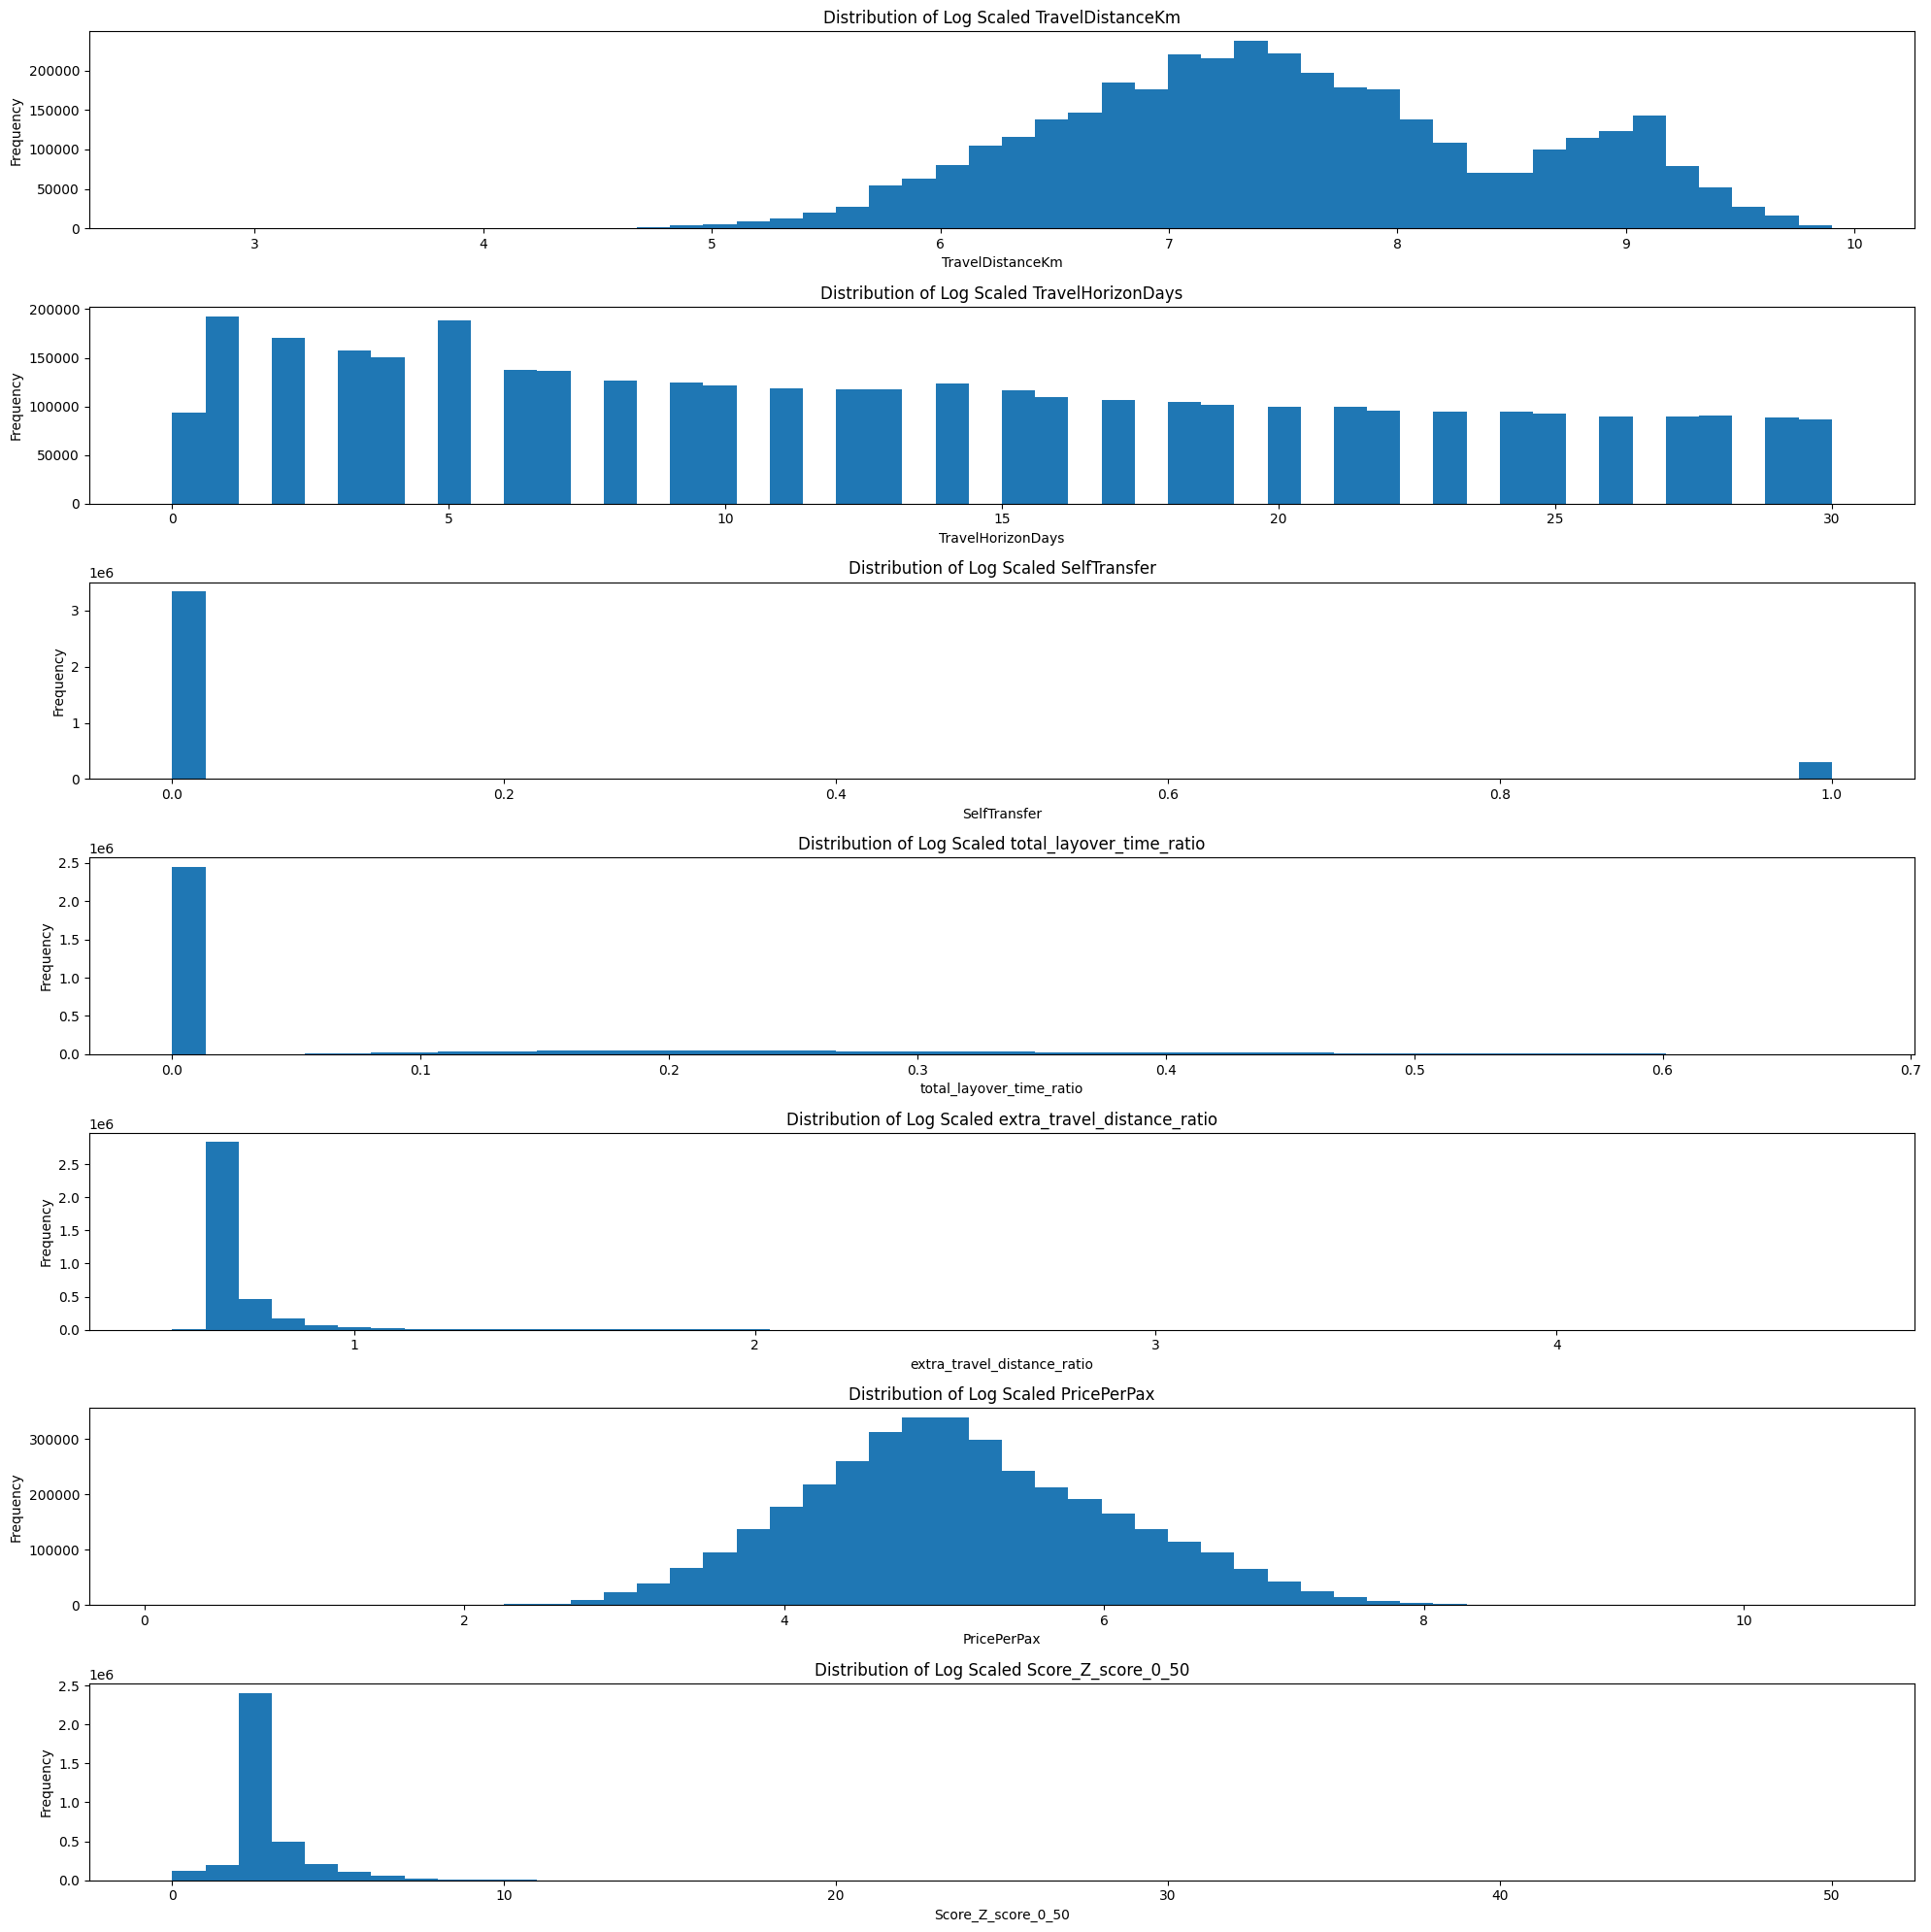

In [27]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist(bins=50)
    plt.title(f'Distribution of Log Scaled {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Apply MinMax Scalar

In [28]:
scaler = MinMaxScaler()


In [29]:
X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'Score_Z_score_0_50')


In [30]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [31]:
# model = Sequential()
# model.add(layers.Dense(64, input_dim=6, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1, activation='linear'))


In [32]:
# model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8833 (34.50 KB)
Trainable params: 8833 (34.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1, verbose=1, mode='min', restore_best_weights=True)


In [34]:
# model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [36]:
# model.fit(X_train, y_train, epochs=15, batch_size=256, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/15
9097/9097 [==============================] - 43s 5ms/step - loss: 1.7513 - mae: 0.8503 - val_loss: 1.7226 - val_mae: 0.8423
Epoch 2/15
9097/9097 [==============================] - 43s 5ms/step - loss: 1.7511 - mae: 0.8502 - val_loss: 1.7226 - val_mae: 0.8457
Epoch 3/15
9097/9097 [==============================] - 52s 6ms/step - loss: 1.7511 - mae: 0.8502 - val_loss: 1.7224 - val_mae: 0.8420
Epoch 4/15
9097/9097 [==============================] - 42s 5ms/step - loss: 1.7509 - mae: 0.8503 - val_loss: 1.7225 - val_mae: 0.8429
Epoch 5/15
9097/9097 [==============================] - 81s 9ms/step - loss: 1.7507 - mae: 0.8501 - val_loss: 1.7221 - val_mae: 0.8488
Epoch 6/15
9097/9097 [==============================] - 47s 5ms/step - loss: 1.7507 - mae: 0.8502 - val_loss: 1.7221 - val_mae: 0.8440
Epoch 7/15
9097/9097 [==============================] - 62s 7ms/step - loss: 1.7505 - mae: 0.8502 - val_loss: 1.7245 - val_mae: 0.8647
Epoch 8/15
9097/9097 [==============================] -

In [37]:
#model.save('new_target_model07Dec23.h5')


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [38]:
model = load_model('../models/new_target_model07Dec23.h5')


In [39]:
# Evaluate the model on the test set
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


22741/22741 [==============================] - 38s 2ms/step - loss: 1.7325 - mae: 0.8446
Test Loss (MSE): 1.7324808835983276
Test Error (MAE): 0.8446187973022461


In [40]:
y_pred = model.predict(X_test)


22741/22741 [==============================] - 33s 1ms/step


In [41]:
y_diff = y_pred.flatten() - y_test


In [42]:
y_diff_abs = y_diff.abs()


<Axes: ylabel='Count'>

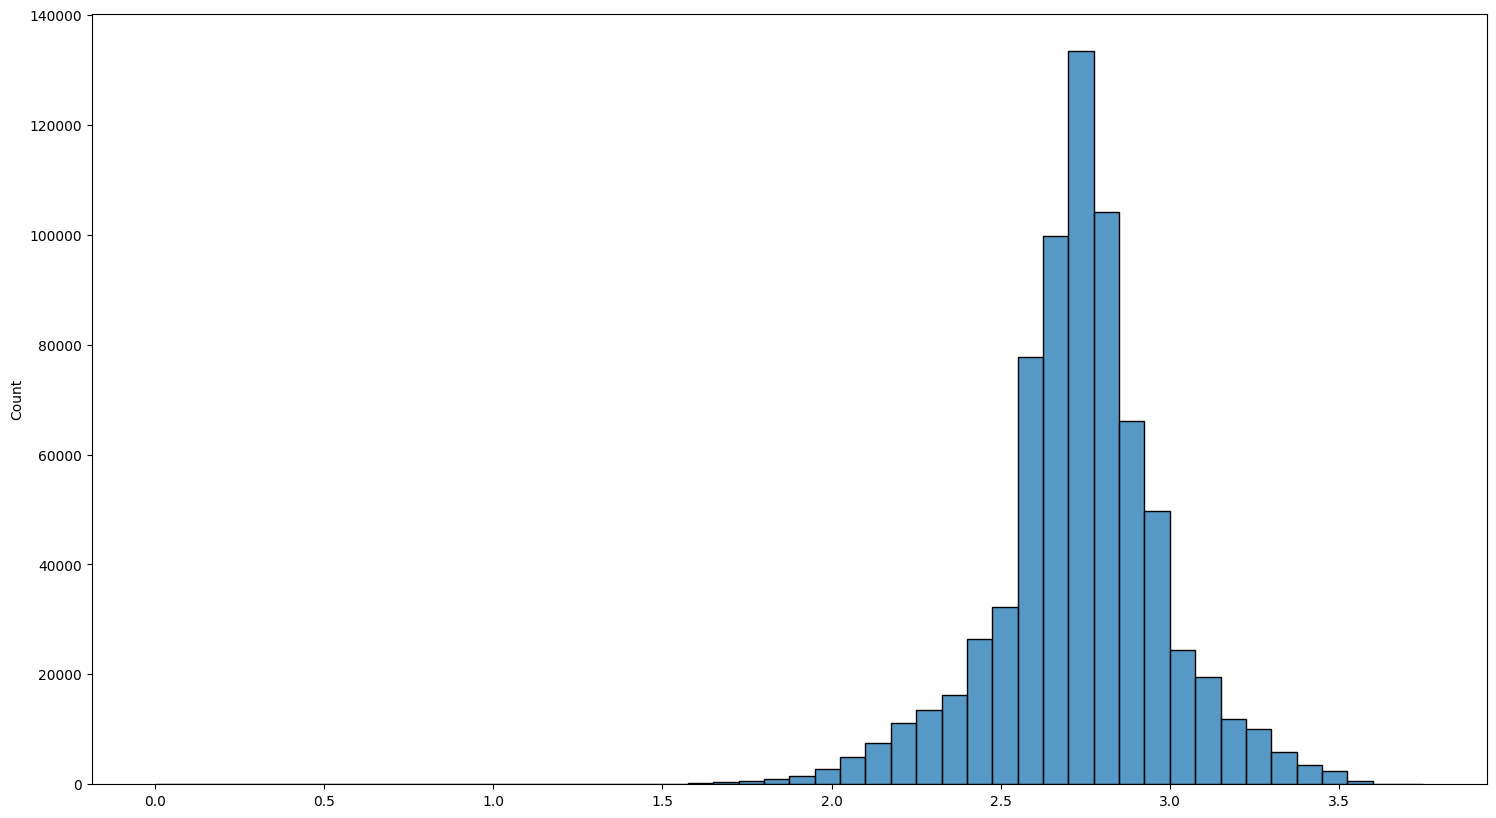

In [45]:
plt.figure(figsize = (18, 10))
sns.histplot(y_pred.flatten(), bins=50)


In [48]:
dohop_test = pd.read_csv("../raw_data/Dohop_Test_Dataset.csv")
dohop_test.head()


,Unnamed: 0,flights,origin,destination,connection_airport,total_minutes,connection_time,days_to_travel,pax,bookings,total_price,total_distance,direct_distance,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,predictions
0,0,"U21806, U23804",MRS,MXP,BOD,160,105,9,1,1,113.633395,1300.563,403.439,1,0.396226,3.223692,113.633395,5.716523
1,1,"IB2628, 3O378",JFK,TNG,BCN,565,170,13,1,1,289.801556,7014.057,5811.312,1,0.231293,1.206966,289.801556,5.369888
2,2,"U21580, U21531",NBE,BRU,GVA,210,125,36,1,1,74.018052,1693.643,1691.602,1,0.373134,1.001207,74.018052,5.272517
3,3,"U28792, U28685",GIB,AMS,LGW,255,250,10,1,1,284.314697,2102.413,1963.491,1,0.495050,1.070753,284.314697,5.489930
4,4,"U28062, Z0783",BCN,MCO,LGW,710,310,107,1,1,438.694302,8130.504,7402.081,1,0.303922,1.098408,438.694302,5.308295


In [49]:
model_columns


['TravelDistanceKm',
 'TravelHorizonDays',
 'SelfTransfer',
 'total_layover_time_ratio',
 'extra_travel_distance_ratio',
 'PricePerPax',
 'Score_Z_score_0_50']

In [50]:
dohop_columns = ["total_distance", "days_to_travel", "SelfTransfer", "total_layover_time_ratio", "extra_travel_distance_ratio", "PricePerPax"]


In [51]:
dohop_test = dohop_test[dohop_columns]


In [55]:
dohop_test.rename(columns={"total_distance": "TravelDistanceKm", "days_to_travel": "TravelHorizonDays"},inplace=True)
dohop_test.columns


Index(['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer',
       'total_layover_time_ratio', 'extra_travel_distance_ratio',
       'PricePerPax'],
      dtype='object')

In [56]:
dohop_test.isna().sum()


TravelDistanceKm               28
TravelHorizonDays               0
SelfTransfer                    0
total_layover_time_ratio        0
extra_travel_distance_ratio    28
PricePerPax                     0
dtype: int64

In [57]:
dohop_test.dropna(inplace=True)
dohop_test.isna().sum()


TravelDistanceKm               0
TravelHorizonDays              0
SelfTransfer                   0
total_layover_time_ratio       0
extra_travel_distance_ratio    0
PricePerPax                    0
dtype: int64

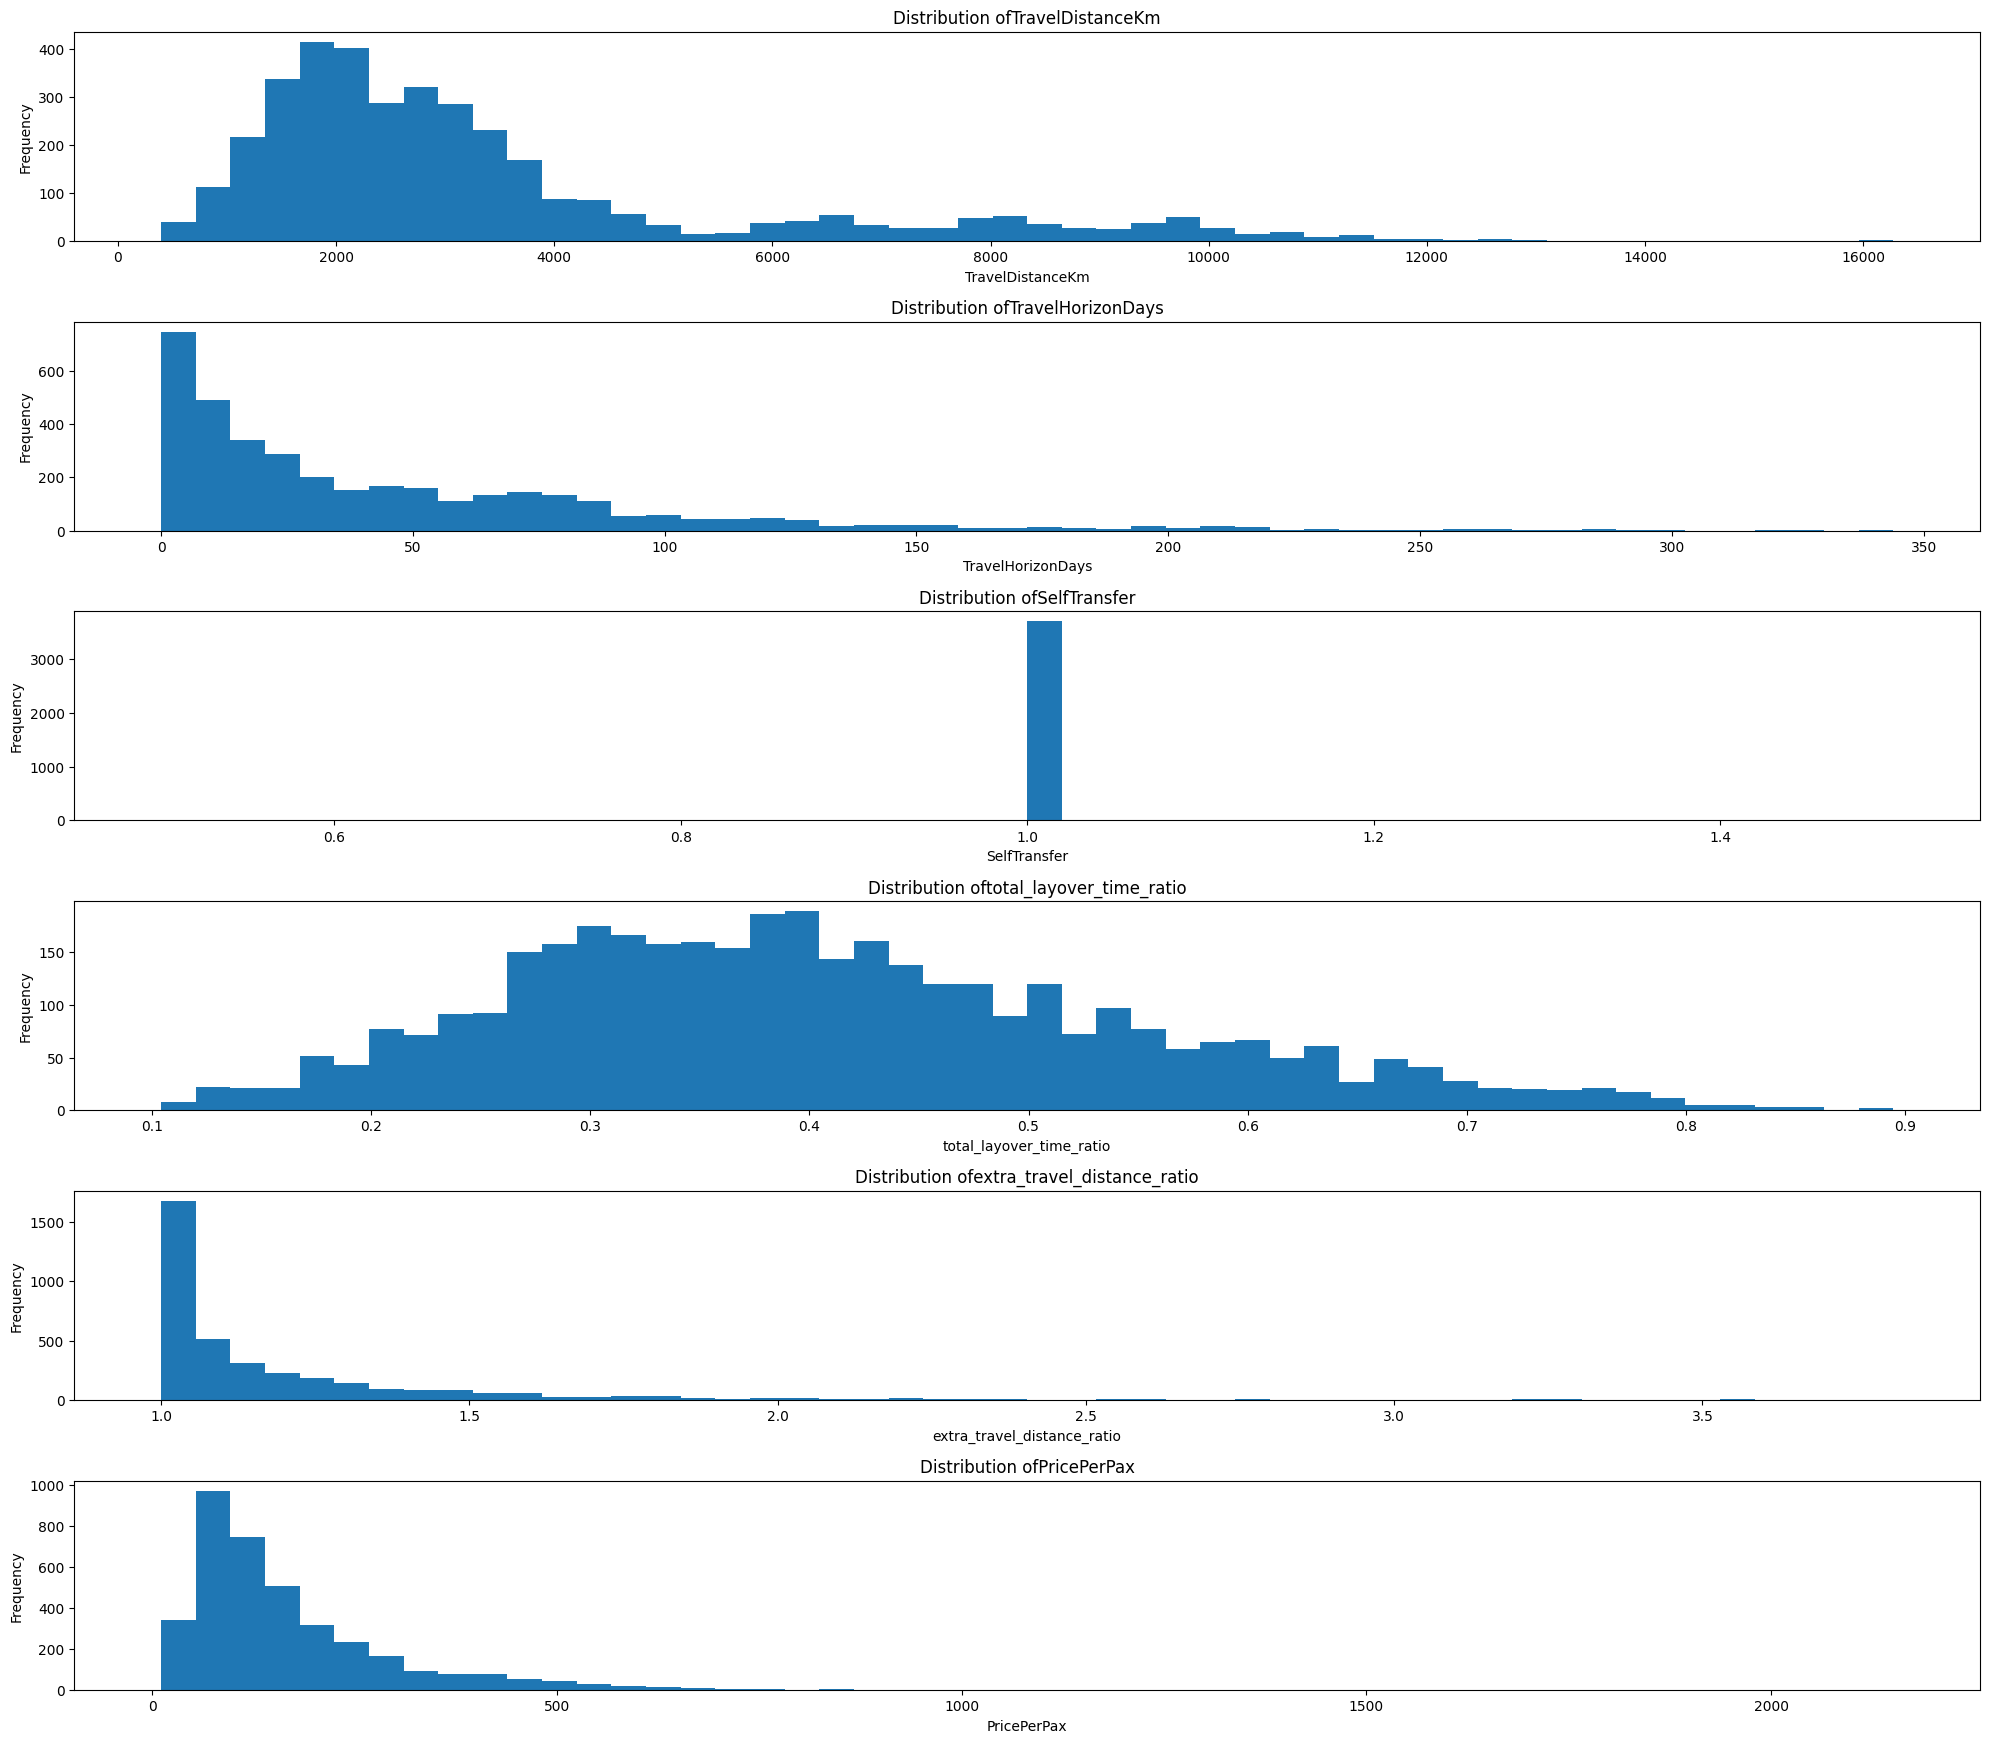

In [59]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(dohop_test.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of{heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [60]:

# Apply the transformation in a loop
for column in columns_to_transform:
    dohop_test.loc[:, column] = np.log1p(dohop_test[column])


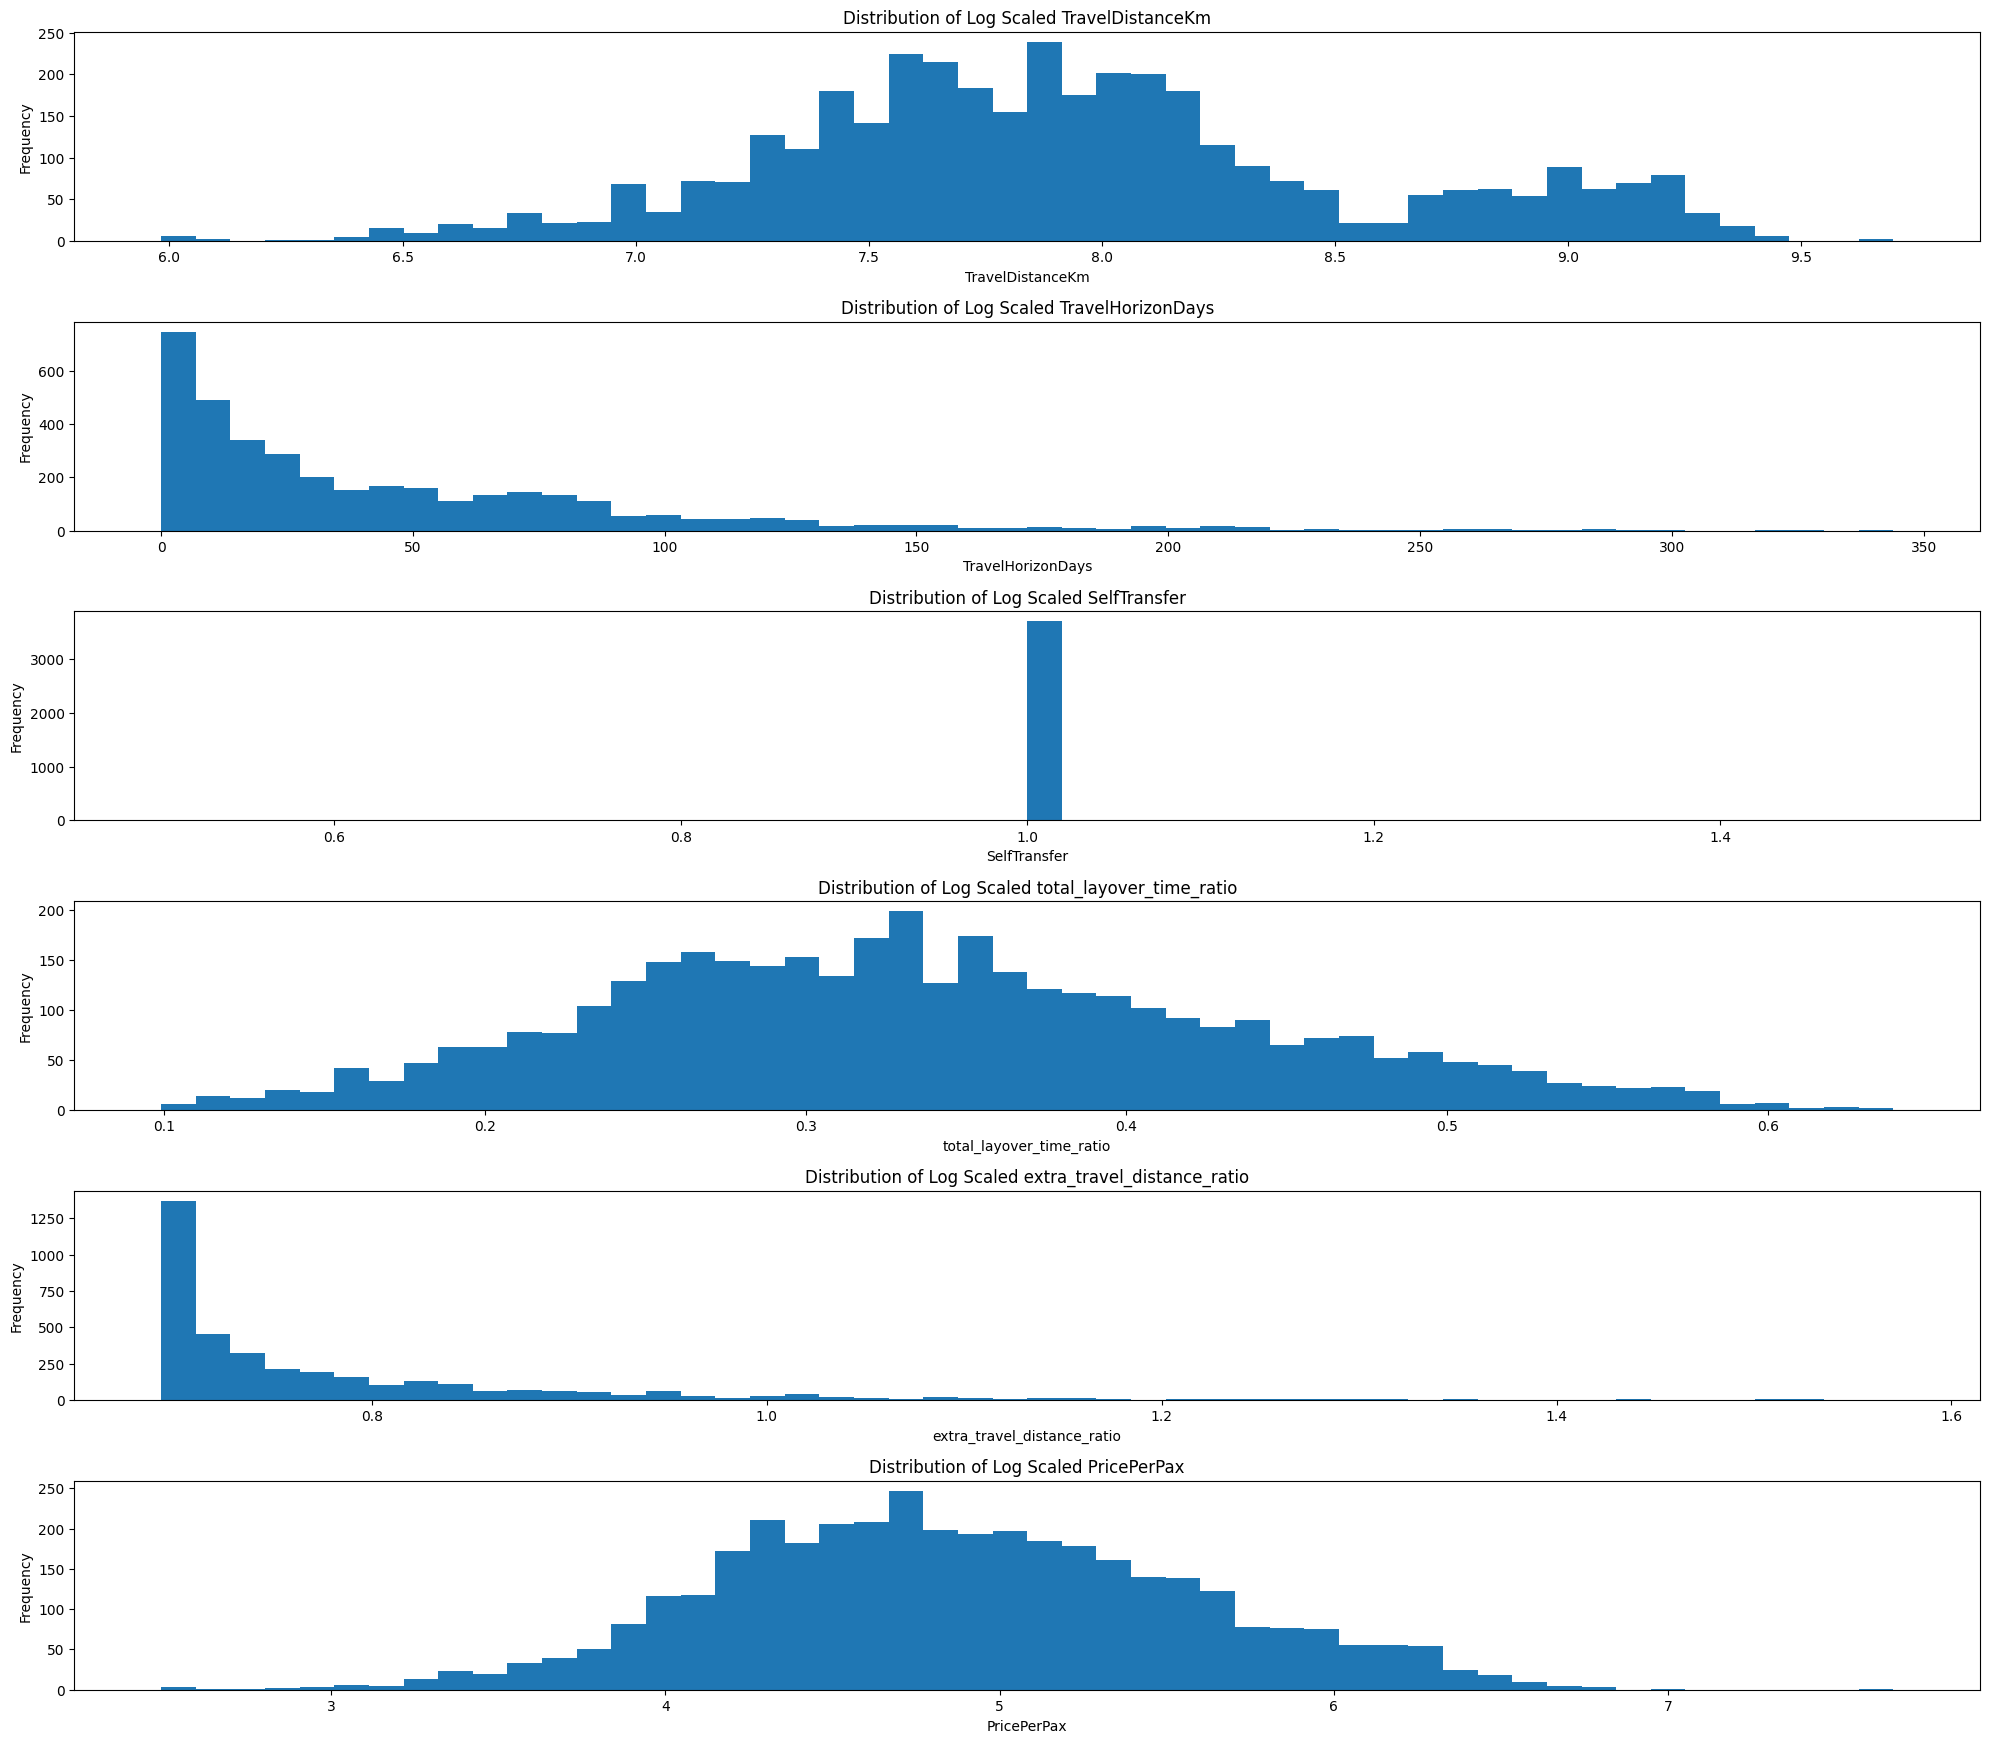

In [62]:
# Set a larger figure size for readability
plt.figure(figsize=(20, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(dohop_test.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    dohop_test[heading].plot.hist(bins=50)
    plt.title(f'Distribution of Log Scaled {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [76]:
dohop_test_array = scaler.transform(dohop_test)


In [81]:
y_dohop_pred = model.predict(dohop_test_array)


  1/116 [..............................] - ETA: 6s

116/116 [==============================] - 1s 5ms/step


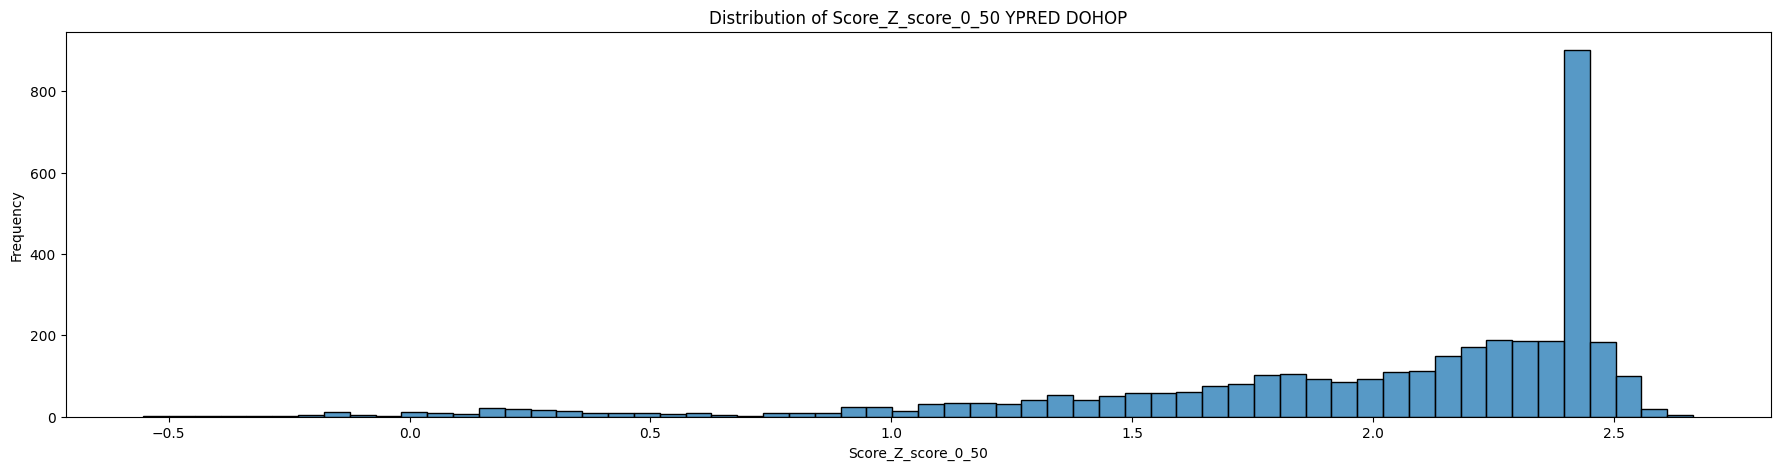

In [89]:
plt.figure(figsize = (22, 5))
sns.histplot(y_dohop_pred.flatten(), bins=60)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50 YPRED DOHOP")
plt.show()


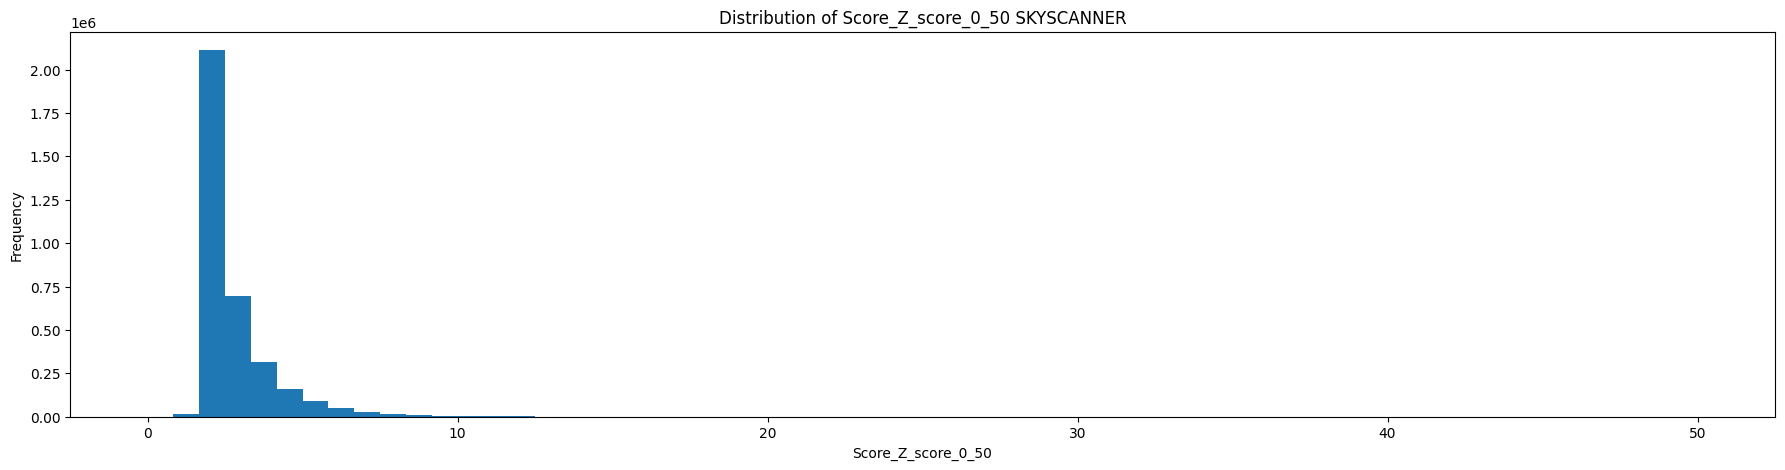

In [90]:
plt.figure(figsize=(22, 5))
plt.hist(data["Score_Z_score_0_50"], bins=60)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50 SKYSCANNER")
plt.show()
